In [1]:
import EoN
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

In [2]:
N = 1000
G = nx.fast_gnp_random_graph(N, 5./(N-1))

In [3]:
node_attribute_dict = {node: 0.5+random.random() for node in G.nodes()}
edge_attribute_dict = {edge: 0.5+random.random() for edge in G.edges()}

nx.set_node_attributes(G, values=node_attribute_dict, name='expose2infect_weight')
nx.set_edge_attributes(G, values=edge_attribute_dict, name='transmission_weight')

In [4]:
# Parameters
sigma =  3.5 
gamma = 13.7
mu, delta = np.linalg.solve(np.array([[1 - 0.01,  -0.01],[-0.15, 1 - 0.15]]), 
                            np.array([[0.01 *(1/gamma)],[0.15 *(1/gamma)]]))

# Spontaneous transitions (without any nbr influence). 
H = nx.DiGraph()
H.add_node('S')
H.add_edge('E', 'I', rate = 1/sigma)                           # Latent period
H.add_edge('I', 'R', rate = 1/gamma)                           # Duration of infectiousness
H.add_edge('H', 'R', rate = 1/(gamma + 7.0))                   # Duration of infectiousness for hospitalized
H.add_edge('I', 'H', rate = delta[0])                          # Hospitalization rate
H.add_edge('I', 'D', rate = mu[0])                             # Death rate 
H.add_edge('H', 'D', rate = (0.1/(1-.1)) * (1/(gamma + 7.0)))  # Death rate for severe cases

In [8]:
(0.1/(1-.1)) * (1/(gamma + 7.0))

0.005367686527106817

In [5]:
# Parameters 
beta = 0.04                               

# Neighbor induced transitions.
J = nx.DiGraph()
J.add_edge(('I', 'S'), ('I', 'E'), rate = beta)        # Transmission rate
J.add_edge(('H', 'S'), ('H', 'E'), rate = beta)        # Transmission rate
J.add_edge(('E', 'S'), ('E', 'E'), rate = .2 * beta)   # Transmission rate

In [6]:
IC = defaultdict(lambda: 'S')
for node in range(200):
    IC[node] = 'I'

In [7]:
return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

res = EoN.Gillespie_simple_contagion(
                    G,                           # Contact network.
                    H,                           # Spontaneous transitions (without any nbr influence).
                    J,                           # Neighbor induced transitions.
                    IC,                          # Initial infected nodes
                    return_statuses,             # 
                    return_full_data = True,
                    tmax = float('Inf')          # Contact network
                )

In [8]:
times, states = res.summary()

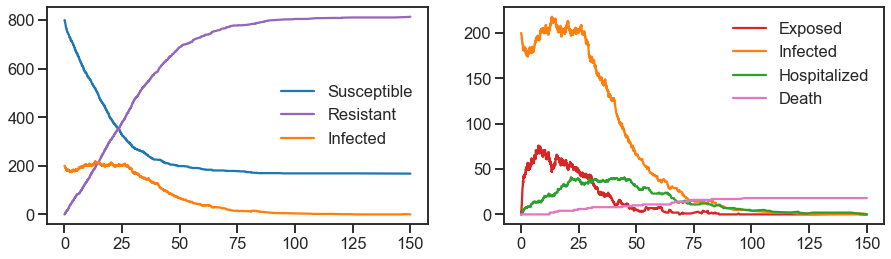

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

axes[0].plot(times, states['S'], label = 'Susceptible', color = 'C0')
axes[0].plot(times, states['R'], label = 'Resistant', color = 'C4')
axes[0].plot(times, states['I'], label = 'Infected', color = 'C1')
axes[0].legend()

axes[1].plot(times, states['E'], label = 'Exposed', color = 'C3')
axes[1].plot(times, states['I'], label = 'Infected', color = 'C1')
axes[1].plot(times, states['H'], label = 'Hospitalized', color = 'C2')
axes[1].plot(times, states['D'], label = 'Death', color = 'C6')
axes[1].legend()

plt.legend();